In [1]:
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker as ticker
import time
from typing import List, Tuple, Callable

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import dependencies
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.utils import shuffle
import joblib
from sklearn.model_selection import cross_validate

from sklearn.neural_network import MLPRegressor

In [24]:
def ANN_Train(X, y, test_size, train_size, k, epochs, hidden_nodes, hidden_layers, batch_size, learning_rate):

    #print("Training ANN model...")

    # Create tuple for hidden layers
    hidden_layer_sizes = tuple(np.full(hidden_layers, hidden_nodes))

    # Split into testing and training data.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, train_size=train_size, random_state=42)

    # Create model
    model = Pipeline([('scaler', StandardScaler(with_mean=True)), ('ANN', MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='adam', batch_size=batch_size, max_iter=epochs, learning_rate_init=learning_rate))])

    #print("Cross validating...")

    # K-fold cross validation
    scores = cross_validate(model, X_train, y_train, cv=k, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

    # Calculate MSE, RMSE, R2 values
    Best_CV_MSE = min(abs(scores['test_neg_mean_squared_error']))
    Best_CV_RMSE = np.sqrt(Best_CV_MSE)
    Best_CV_R2 = max(scores['test_r2'])
    Worst_CV_MSE = max(abs(scores['test_neg_mean_squared_error']))
    Worst_CV_RMSE = np.sqrt(Worst_CV_MSE)
    Worst_CV_R2 = min(scores['test_r2'])
    Ave_CV_MSE = np.average(abs(scores['test_neg_mean_squared_error']))
    Ave_CV_RMSE = np.sqrt(Ave_CV_MSE)
    Ave_CV_R2 = np.average(scores['test_r2'])

    if verbose:
        # Print out cross validation history data
        print("~~~~ Cross Validation Results ~~~~")
        print("Best MSE CV: ", Best_CV_MSE)
        print("Best RMSE CV: ", Best_CV_RMSE)
        print("Best R2 CV: ", Best_CV_R2)
        print("Worst MSE CV: ", Worst_CV_MSE)
        print("Worst RMSE CV: ", Worst_CV_RMSE)
        print("Worst R2 CV: ", Worst_CV_R2)
        print('Average MSE CV: ', Ave_CV_MSE)
        print('Average RMSE CV: ', Ave_CV_RMSE)
        print("Average R2 CV: ", Ave_CV_R2)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    #print("Fitting model...")

    # Fit model
    model.fit(X_train, y_train)

    # Output cross validation data
    CrossValData = [Best_CV_MSE, Best_CV_RMSE, Best_CV_R2, Worst_CV_MSE, Worst_CV_RMSE, Worst_CV_R2, Ave_CV_MSE, Ave_CV_RMSE, Ave_CV_R2]

    return model, X_test, y_test, CrossValData

def ANN_Test(model, X_test, y_test, verbose=False, plot=False):

    print("Testing model...")

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate R2, RMSE, and MSE metrics for test data
    Test_R2 = r2_score(y_test, y_pred)
    Test_MSE = mean_squared_error(y_test, y_pred, squared=True)
    Test_RMSE = np.sqrt(Test_MSE)
    
    if verbose:
        # Print model info after CV
        print("~~~~~~~~~ Final Model Structure Info ~~~~~~~~~")
        print("Number of Layers: ", model[1].n_layers_)
        print("Number of input features: ", model[1].n_features_in_)
        print("Number of outputs: ", model[1].n_outputs_)
        print("Number of iterations ran: ", model[1].n_iter_)
        print("~~~~~~~~~ Final Model Error Info ~~~~~~~~~")
        print("Test MSE: ", Test_MSE)
        print("Test RMSE: ", Test_RMSE)
        print("Test R2: ", Test_R2)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    if plot:
        # Plot ANN results.
        fig, ax = plt.subplots(1, 2)
        fig.suptitle("ANN Results")

        ax[0].plot(np.linspace(1, len(model[1].loss_curve_), len(model[1].loss_curve_)), model[1].loss_curve_)
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss (Mean Squared Error)")
        ax[0].set_title('Epoch History, MSE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}'.format(Test_MSE, Test_RMSE, Test_R2), fontsize=7)

        # Parity Plot
        ax[1].plot(y_test, y_pred, 'r*')
        ax[1].set_xlabel("y_test")
        ax[1].set_ylabel("y_pred")
        ax[1].set_title('Parity Plot, MSE: {:.2f}, RMSE: {:.2f}, R2: {:.2f}'.format(Test_MSE, Test_RMSE, Test_R2), fontsize=7)
        plt.tight_layout()

    return [Test_R2, Test_RMSE, Test_MSE]

In [6]:
# Dataset Import
df = pd.read_csv('merged_beadnumber.csv', usecols=lambda x: 'Unnamed' not in x)

## Artificial Neural Network Parameters
### Constants 
 - test_size, train_size = 0.2, 0.8 - standard train/test split
 - k: cross-validation folds 
 - activation: Activation function for the hidden layer
 - solver: solver for weight optimization (adam)
  - epochs: Maximum number of iterations for solving
 - learning_rate : Initial learning weight for step-size in updating weights.
 ### Hyperparameters
 - Hidden_layers_sizes: Tuples of layers and those layer sizes The ith element represents the number of neurons in the ith hidden layer.
 - hidden_nodes: Number of neurons per hidden layer
 - batch_size: Size of minibatches

In [ ]:
# Define ANN model hidden layer structure and training parameters

'''
# Develop hidden layer tuples 
hidden_layers = [1, 3, 5]
hidden_nodes = [3, 5, 7]
hidden_layer_sizes  = [tuple(np.full(lay, nodes)) for lay in hidden_layers for nodes in hidden_nodes]
hidden_layer_sizes += [(3,5,3), (3,5,7,5,3), (5,7,5)]

# Initialize parmesan cheese
params = {'hidden_layer_sizes': hidden_layer_sizes,
         'learning_rate_init': 0.01,
         'epochs': 500,
         'batch_size': 100,
         }

valtype = 'MovAvg'
val = "Current" # ['Current', 'Voltage', 'CTWD']
# 
featlist = ['std', 'skew', 'kurt', 'mean']
features = [f'{feat}_{valtype}{val}' for feat in featlist]
print(features)
    # Parse dataset
    '''
def ANN_GridSearch(X_train, X_test, y_train, y_test, params):
    model = Pipeline([('scaler', StandardScaler(with_mean=True)), 
                  ('ANN', MLPRegressor(activation='relu', solver='adam'))])
    clf = GridSearchCV(model, params)
    clf.fit(X, y)
    score = clf.score(X_test, y_test)
    #results = clf.cv_results_
    #for mean_score, params in zip(results["mean_test_score"], results["params"]):
    #    print(params, "=>", mean_score)
        

In [22]:
# Filter by variable type 
allVars = [col for col in df.columns if '_' in col]
movAvgCols = [col for col in df.columns if 'MovAvg' in col]
noisyVars = [col for col in allVars if col not in movAvgCols]

Voltage
~~~~ Cross Validation Results ~~~~
Best MSE CV:  14.477015978221194
Best RMSE CV:  3.804867406128786
Best R2 CV:  -0.026700817323046033
Worst MSE CV:  21.764146521407188
Worst RMSE CV:  4.665205946301533
Worst R2 CV:  -0.15134535341549069
Average MSE CV:  17.04647344916495
Average RMSE CV:  4.1287375127470805
Average R2 CV:  -0.10196651697683923
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing model...
~~~~~~~~~ Final Model Structure Info ~~~~~~~~~
Number of Layers:  7
Number of input features:  3
Number of outputs:  5
Number of iterations ran:  234
~~~~~~~~~ Final Model Error Info ~~~~~~~~~
Test MSE:  15.704033351826746
Test RMSE:  3.9628314816336494
Test R2:  -0.11610103237549192
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Current


/Users/nikkivanhandel/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


~~~~ Cross Validation Results ~~~~
Best MSE CV:  11.77804646416222
Best RMSE CV:  3.431915859132071
Best R2 CV:  -0.015418070553869078
Worst MSE CV:  22.170629932607973
Worst RMSE CV:  4.708569839410686
Worst R2 CV:  -0.2302618059822527
Average MSE CV:  16.76973061331794
Average RMSE CV:  4.0950861545659745
Average R2 CV:  -0.11312336997787051
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/Users/nikkivanhandel/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


Testing model...
~~~~~~~~~ Final Model Structure Info ~~~~~~~~~
Number of Layers:  7
Number of input features:  3
Number of outputs:  5
Number of iterations ran:  750
~~~~~~~~~ Final Model Error Info ~~~~~~~~~
Test MSE:  13.652603825633326
Test RMSE:  3.6949430070886513
Test R2:  -0.0458655659828137
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CTWD
~~~~ Cross Validation Results ~~~~
Best MSE CV:  14.103052627695835
Best RMSE CV:  3.755403124525493
Best R2 CV:  0.006598618033447701
Worst MSE CV:  21.474148003061597
Worst RMSE CV:  4.63402071672771
Worst R2 CV:  -0.11909548644662389
Average MSE CV:  16.736625972371318
Average RMSE CV:  4.091042162135624
Average R2 CV:  -0.07948747752376083
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing model...
~~~~~~~~~ Final Model Structure Info ~~~~~~~~~
Number of Layers:  7
Number of input features:  3
Number of outputs:  5
Number of iterations ran:  483
~~~~~~~~~ Final Model Error Info ~~~~~~~~~
Test MSE:  15.692119977024182
Test RMSE:  3.9613280572333545
Test R2:  -

/Users/nikkivanhandel/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (750) reached and the optimization hasn't converged yet.
  warnings.warn(


~~~~ Cross Validation Results ~~~~
Best MSE CV:  9.866051247435916
Best RMSE CV:  3.141027100716566
Best R2 CV:  0.06036649335137043
Worst MSE CV:  14.308322798188566
Worst RMSE CV:  3.78263437278685
Worst R2 CV:  -0.7669759310795867
Average MSE CV:  12.392841394276449
Average RMSE CV:  3.5203467718786525
Average R2 CV:  -0.2550103388269685
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing model...
~~~~~~~~~ Final Model Structure Info ~~~~~~~~~
Number of Layers:  7
Number of input features:  3
Number of outputs:  5
Number of iterations ran:  441
~~~~~~~~~ Final Model Error Info ~~~~~~~~~
Test MSE:  12.232766453434275
Test RMSE:  3.497537198291717
Test R2:  -0.11780364538786843
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CTWD
~~~~ Cross Validation Results ~~~~
Best MSE CV:  10.96423389265245
Best RMSE CV:  3.3112284567290806
Best R2 CV:  -0.07743048224147801
Worst MSE CV:  14.546123392724121
Worst RMSE CV:  3.813938042591164
Worst R2 CV:  -0.3992419281911935
Average MSE CV:  12.54648960007699
Average RMSE 

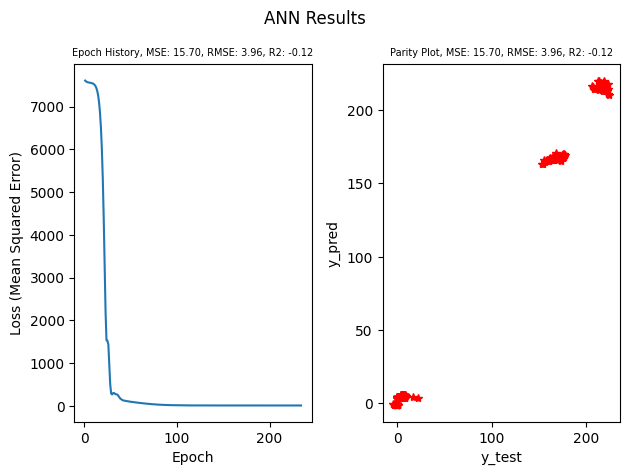

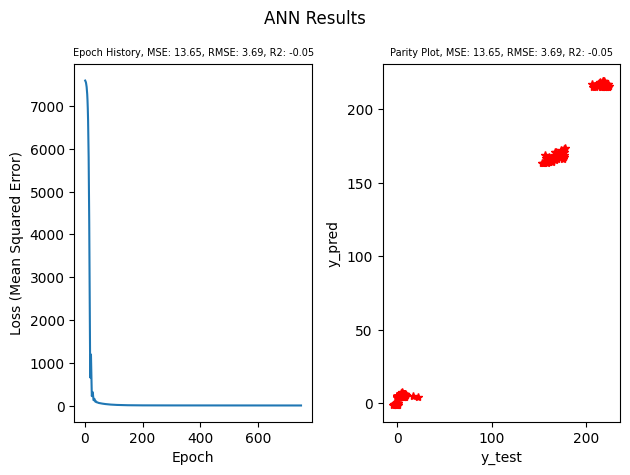

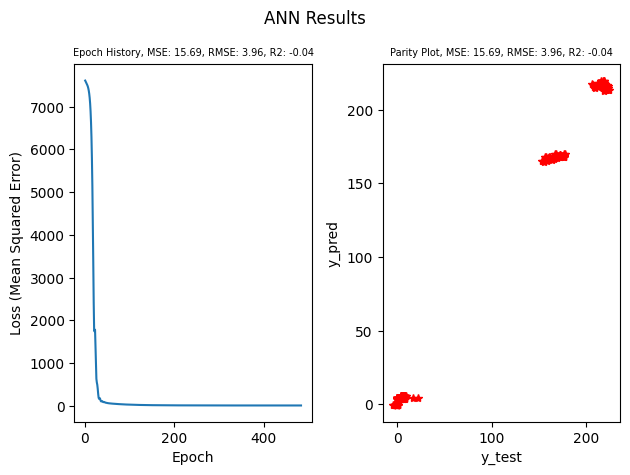

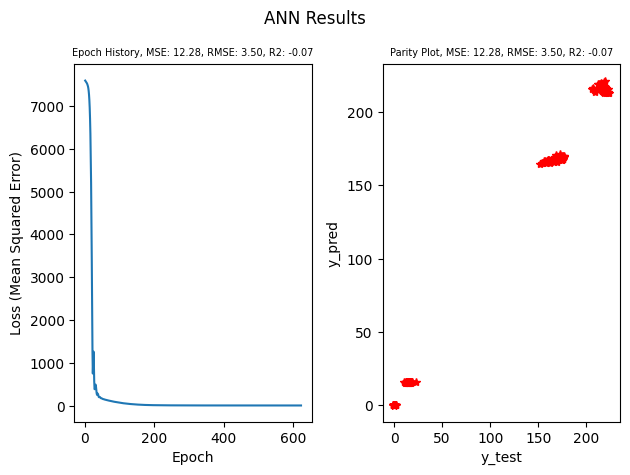

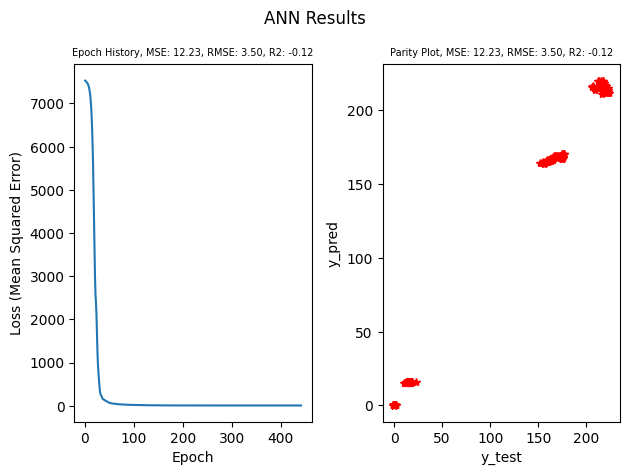

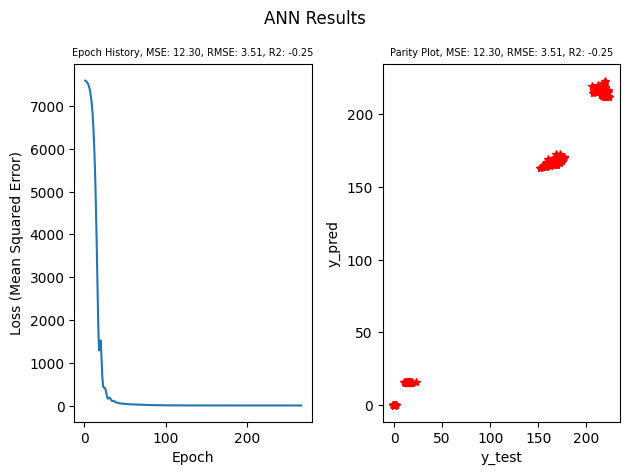

In [29]:
test_size, train_size = 0.2, 0.8
k = 5

# e.g.
hidden_layers = 5
hidden_nodes = 10
test_size = 0.2
train_size = 0.8
k = 5
batch_size = 100
epochs = 750
learning_rate = 0.01

datatypes = ['Voltage', 'Current', 'CTWD']
# Compare effectiveness of datatypes
coltypes = [movAvgCols, noisyVars]
for coltype in coltypes:
    for datatype in datatypes: 
        print(datatype)
        X = df.iloc[:,0:3]
        cols = [col for col in coltype if 'Voltage' in col]
        y = df.loc[:, cols]
        model, X_test, y_test, CrossValData = ANN_Train(X, y, test_size, train_size, k, epochs, hidden_nodes, 
                                                        hidden_layers, batch_size, learning_rate)
        Test_R2, Test_RMSE, Test_MSE = ANN_Test(model, X_test, y_test)


# 